### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_valid'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

plot_gene = 'ATRX'
metric = 'aupr'

output_plots = True
output_plots_dir = cfg.cancer_type_lasso_range_dir

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df = nz_coefs_df[nz_coefs_df.gene == plot_gene].copy()
nz_coefs_df.head()

,gene,cancer_type,lasso_param,seed,fold,nz_coefs
3280,ATRX,BLCA,0.001,42,0,5961
3281,ATRX,BLCA,0.001,42,1,6120
3282,ATRX,BLCA,0.001,42,2,5988
3283,ATRX,BLCA,0.001,42,3,6030
3284,ATRX,BLCA,0.005,1,0,2507


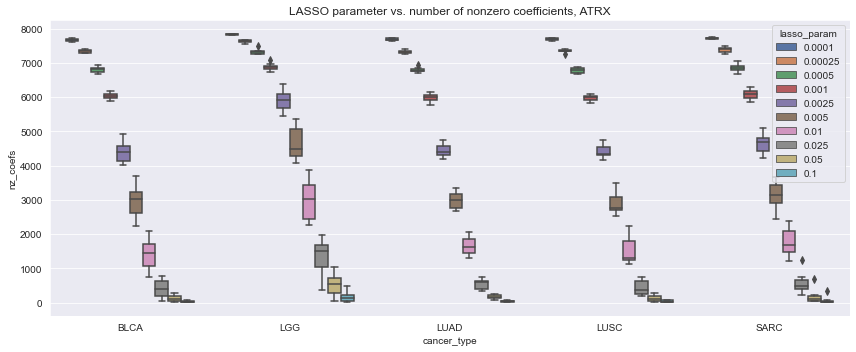

In [4]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param'
)
plt.title(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}')
plt.tight_layout()

### Get performance information for each lasso penalty

In [5]:
perf_df = au.load_prediction_results_lasso_range(results_dir, training_dataset)
perf_df = perf_df[perf_df.gene == plot_gene].copy()
perf_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,0.91682,0.56068,ATRX,SARC,signal,1,train,0,all_other_cancers,0.025
1,0.47010,0.22908,ATRX,SARC,signal,1,test,0,all_other_cancers,0.025
2,0.72059,0.36778,ATRX,SARC,signal,1,cv,0,all_other_cancers,0.025
3,0.87298,0.42984,ATRX,SARC,signal,1,train,1,all_other_cancers,0.025
4,0.58916,0.35918,ATRX,SARC,signal,1,test,1,all_other_cancers,0.025


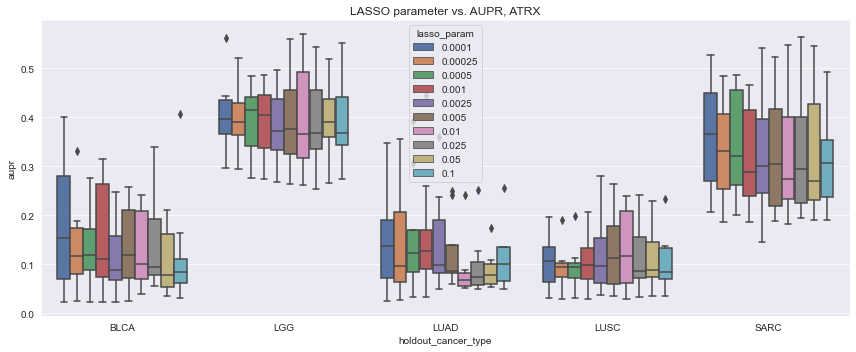

In [6]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=(
        perf_df[(perf_df.signal == 'signal') &
                (perf_df.data_type == 'test')]
          .sort_values(by=['holdout_cancer_type', 'lasso_param'])
    ), x='holdout_cancer_type', y=metric, hue='lasso_param'
)
plt.title(f'LASSO parameter vs. {metric.upper()}, {plot_gene}')
plt.tight_layout()

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(output_plots_dir / f'{plot_gene}_lasso_boxes.png',
                dpi=200, bbox_inches='tight')

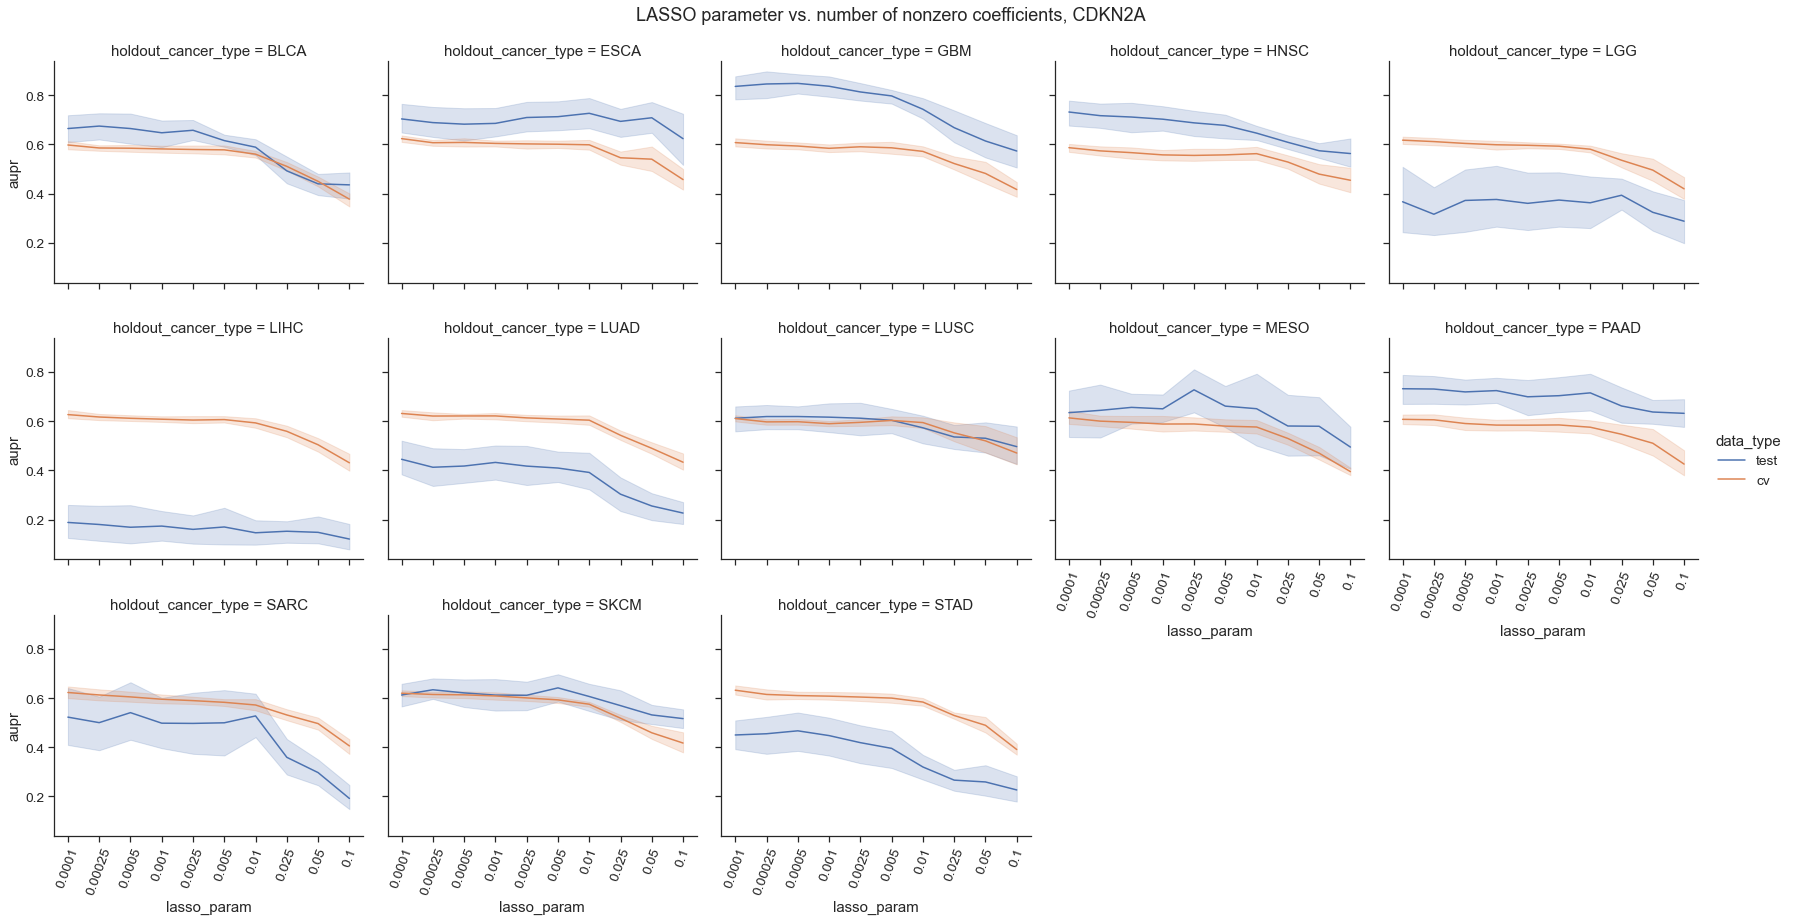

In [24]:
sns.set({'figure.figsize': (12, 5)})
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal') &
            (perf_df.data_type.isin(['cv', 'test']))]
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)

with sns.plotting_context('notebook', font_scale=1.25):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        kind='line', col='holdout_cancer_type',
        col_wrap=5, height=4, aspect=1.2
    )
    g.set_xticklabels(rotation=70)
    plt.suptitle(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}', y=1.025)

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_lasso_facets.png',
                dpi=200, bbox_inches='tight')

### Compare feature selection with performance

In [8]:
coefs_perf_df = (nz_coefs_df
    .rename(columns={'cancer_type': 'holdout_cancer_type'})
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal'])
)

coefs_perf_df.head()

,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type,experiment
0,ATRX,BLCA,0.001,42,0,5961,0.99848,0.991960,train,all_other_cancers
1,ATRX,BLCA,0.001,42,0,5961,0.59355,0.259540,test,all_other_cancers
2,ATRX,BLCA,0.001,42,0,5961,0.78258,0.492820,cv,all_other_cancers
3,ATRX,BLCA,0.001,42,1,6120,0.99696,0.979360,train,all_other_cancers
4,ATRX,BLCA,0.001,42,1,6120,0.56344,0.069471,test,all_other_cancers


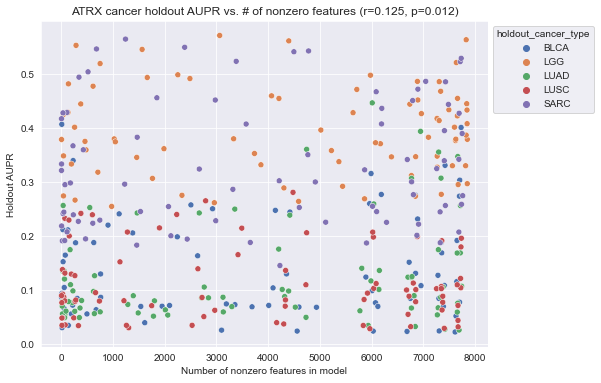

In [9]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

plot_df = (
    coefs_perf_df[coefs_perf_df.data_type == 'test']
      .sort_values(by='holdout_cancer_type')
)
r, p = pearsonr(plot_df.nz_coefs.values, plot_df.aupr.values)

ax = sns.scatterplot(data=plot_df, x='nz_coefs', y='aupr', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} cancer holdout AUPR vs. # of nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Holdout AUPR')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_holdout_perf.png',
                dpi=200, bbox_inches='tight')

In [10]:
# look at correlation for each cancer type individually
# positive correlation => more features, better performance
corr_cancer_type_df = []

for cancer_type in coefs_perf_df.holdout_cancer_type.unique():
    corr_df = coefs_perf_df[
        (coefs_perf_df.holdout_cancer_type == cancer_type) &
        (coefs_perf_df.data_type == 'test')
    ]
    r, p = pearsonr(corr_df.nz_coefs.values, corr_df.aupr.values)
    corr_cancer_type_df.append(
        [plot_gene, cancer_type, r, p]
    )
    
corr_cancer_type_df = pd.DataFrame(
    corr_cancer_type_df,
    columns=['gene', 'cancer_type', 'pearson_r', 'pearson_pval']
).sort_values(by='pearson_r', ascending=False)

corr_cancer_type_df

,gene,cancer_type,pearson_r,pearson_pval
4,ATRX,LUAD,0.263758,0.018078
0,ATRX,BLCA,0.109390,0.334083
3,ATRX,SARC,0.108352,0.338722
1,ATRX,LGG,0.004041,0.971624
2,ATRX,LUSC,-0.064690,0.568614


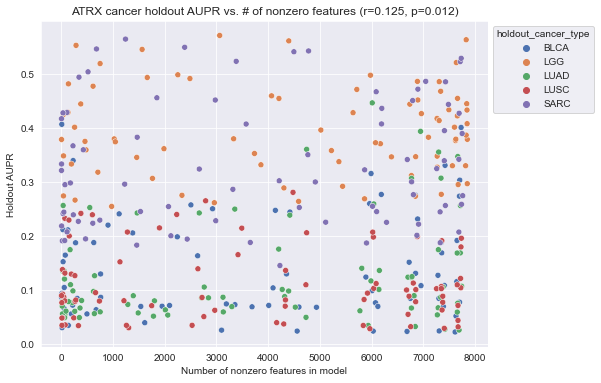

In [11]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

top_cancers = corr_cancer_type_df.cancer_type.values[:5]
    
plot_df = (
    coefs_perf_df[(coefs_perf_df.holdout_cancer_type.isin(top_cancers)) &
                  (coefs_perf_df.data_type == 'test')]
      .sort_values(by='holdout_cancer_type')
)
r, p = pearsonr(plot_df.nz_coefs.values, plot_df.aupr.values)

ax = sns.scatterplot(data=plot_df, x='nz_coefs', y='aupr', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} cancer holdout AUPR vs. # of nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Holdout AUPR')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_holdout_perf_top_cancers.png',
                dpi=200, bbox_inches='tight')

In [12]:
coefs_perf_pivot_df = coefs_perf_df.pivot(
    index=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param', 'nz_coefs'],
    columns='data_type',
    values=['auroc', 'aupr']
)
coefs_perf_pivot_df.columns = ['_'.join(col).strip() for col in coefs_perf_pivot_df.columns.values]
coefs_perf_pivot_df.reset_index(inplace=True)

coefs_perf_pivot_df

,gene,holdout_cancer_type,seed,fold,lasso_param,nz_coefs,auroc_cv,auroc_test,auroc_train,aupr_cv,aupr_test,aupr_train
0,ATRX,BLCA,1,0,0.0001,7649,0.77988,0.67210,0.99993,0.40573,0.19145,0.99969
1,ATRX,BLCA,1,0,0.00025,7353,0.78058,0.60870,0.99910,0.42214,0.16854,0.99543
2,ATRX,BLCA,1,0,0.0005,6888,0.77359,0.51630,0.99883,0.39900,0.23121,0.99387
3,ATRX,BLCA,1,0,0.001,6186,0.78459,0.57609,0.99714,0.45190,0.27662,0.98552
4,ATRX,BLCA,1,0,0.0025,4139,0.79707,0.58696,0.99625,0.46819,0.24719,0.98018
...,...,...,...,...,...,...,...,...,...,...,...,...
395,ATRX,SARC,42,3,0.005,3574,0.80051,0.69031,0.98622,0.54964,0.40683,0.89801
396,ATRX,SARC,42,3,0.01,2386,0.78429,0.73522,0.96447,0.45264,0.54882,0.75684
397,ATRX,SARC,42,3,0.025,1243,0.73335,0.69504,0.87774,0.27783,0.56396,0.44289
398,ATRX,SARC,42,3,0.05,682,0.70822,0.68558,0.77040,0.24394,0.54569,0.29940


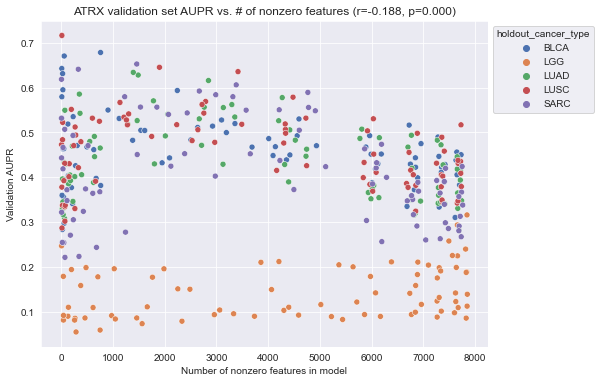

In [13]:
# plot validation performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})
r, p = pearsonr(coefs_perf_pivot_df.nz_coefs.values, coefs_perf_pivot_df.aupr_cv.values)

ax = sns.scatterplot(data=coefs_perf_pivot_df, x='nz_coefs', y='aupr_cv', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} validation set AUPR vs. # of nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Validation AUPR')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_validation_perf.png',
                dpi=200, bbox_inches='tight')

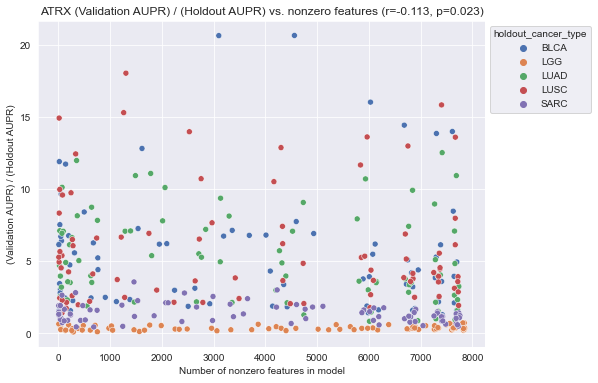

In [14]:
# plot validation performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

coefs_perf_pivot_df['cv_test_aupr_ratio'] = (
    coefs_perf_pivot_df['aupr_cv']/ coefs_perf_pivot_df['aupr_test']
)
r, p = pearsonr(coefs_perf_pivot_df.nz_coefs.values, coefs_perf_pivot_df.cv_test_aupr_ratio.values)

ax = sns.scatterplot(data=coefs_perf_pivot_df, x='nz_coefs', y='cv_test_aupr_ratio', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} (Validation AUPR) / (Holdout AUPR) vs. nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('(Validation AUPR) / (Holdout AUPR)')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_perf_ratio.png',
                dpi=200, bbox_inches='tight')

For this limited set of genes/cancer types, there doesn't seem to be much of a relationship between model size and "performance", for any of these three ways of defining performance.

A better way to explore correlation between model size and performance might be to look at the partial correlation while controlling for cancer type - we'll explore this in the future.